Import the Neccesary Libraries

In [1]:
# Import the neccesary libraries needed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
from numpy import insert
import os
import time

# keras tuner for hyperparameter tuning
#import keras_tuner as kt

# tensorflow Libraries
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.models import load_model

Import the CSV Training and Testing Data Sets

In [2]:
# Import the csv's (IMPORTANT: You need at least 16 Gb of RAM to proceed)

train=pd.read_csv(r'C:\Users\rferr\OneDrive - University of Massachusetts Dartmouth\ECE457_Senior_Design\CSV_Files\0001_1404.038_port_FinalCleaned_RollReady.csv')
test=pd.read_csv(r'C:\Users\rferr\OneDrive - University of Massachusetts Dartmouth\ECE457_Senior_Design\CSV_Files\0001_1404.038_stbd_FinalCleaned_RollReady.csv')


Split up the Features and Labels from both the Training and Testing Datasets

In [3]:
# Split up the features and labels from both the training and testing datasets
x_train=train.iloc[:,3:25]
#x_train['TWTT']=train.iloc[:,28]  I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
x_train['Amplitude']=train.iloc[:,29]
x_train['Roll'] = x_train['Roll']

x_test=test.iloc[:,3:25]
#x_test['TWTT']=test.iloc[:,28] I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
x_test['Roll'] = x_test['Roll']
x_test['Amplitude']=test.iloc[:,29]

y_train=train.iloc[:,26]

y_test=test.iloc[:,26]

In [4]:
x_train

,SampleTimeDelay,I1,Q1,I2,Q2,I3,Q3,I4,Q4,I5,...,I7,Q7,I8,Q8,I9,Q9,I10,Q10,Roll,Amplitude
0,0.031901,11.46875,50.12500,-49.75000,-41.718750,72.93750,7.437500,-63.062500,35.437500,27.281250,...,-52.562500,-40.156250,60.656250,6.218750,-41.343750,40.375000,19.562500,-68.031250,1.043701,21
1,0.031916,3.62500,13.34375,-16.03125,-16.656250,24.68750,10.093750,-19.875000,4.156250,3.312500,...,-10.031250,1.406250,4.968750,-6.281250,8.187500,7.375000,-13.531250,-0.375000,1.043701,24
2,0.031947,-15.84375,37.25000,-14.12500,-40.781250,43.09375,28.718750,-56.375000,9.750000,43.218750,...,-35.750000,-55.312500,65.218750,27.218750,-67.156250,24.968750,45.875000,-72.062500,1.043701,43
3,0.031962,-3.31250,121.34375,-96.25000,-112.593750,156.46875,47.968750,-151.093750,55.812500,71.281250,...,-119.437500,-94.500000,137.750000,8.562500,-91.656250,98.187500,24.437500,-156.968750,1.043701,14
4,0.031977,44.46875,86.15625,-118.75000,-51.562500,134.46875,-18.375000,-85.968750,91.781250,-10.500000,...,-126.281250,-4.875000,90.031250,-65.625000,1.125000,109.062500,-77.750000,-102.375000,1.043701,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635094,0.099403,-26.40625,6.56250,-3.90625,18.796875,5.90625,9.125000,7.593750,6.531250,14.375000,...,-9.828125,-16.390625,-19.718750,2.109375,-1.765625,12.890625,6.500000,7.578125,0.758057,14
3635095,0.099419,-40.06250,16.34375,-11.12500,38.437500,20.62500,33.406250,41.968750,4.953125,28.296875,...,-38.250000,-13.375000,-35.125000,19.359375,-3.390625,35.953125,28.390625,24.609375,0.758057,18
3635096,0.099434,-16.90625,18.75000,-4.96875,29.453125,29.06250,31.421875,44.828125,-13.218750,6.796875,...,-33.703125,9.156250,-18.171875,20.140625,-6.890625,36.171875,40.296875,27.734375,0.758057,19
3635097,0.099450,40.43750,28.31250,41.90625,-6.828125,31.34375,-35.531250,-15.078125,-51.843750,-57.734375,...,7.484375,54.796875,41.265625,18.406250,29.671875,-9.234375,20.515625,-36.531250,0.758057,22


Scale the Feaures from -1 to 1 so that Training is Easier for the Model

In [5]:
# Scale the Features and Labels from [-1,1]
s1=MinMaxScaler(feature_range=(0,1))
#s1=MinMaxScaler(feature_range=(0,1))
x_train_scale=s1.fit_transform(x_train)

#s2=MinMaxScaler(feature_range=(0,1))
#s2=MinMaxScaler(feature_range=(0,1))
x_test_scale=s1.transform(x_test)
x_test_scale=x_test_scale
x_test_scale[:, 21] = -x_test_scale[:, 21]
# Scale DOA's from (0 to 1)
#s3=MinMaxScaler(feature_range=(0,1))
#y_train_scale = s3.fit_transform(train[['DOA']])
y_train_scale= y_train.to_numpy()

#s4=MinMaxScaler(feature_range=(0,1))
#y_test_scale = s4.fit_transform(test[['DOA']])
y_test_scale= y_test.to_numpy()

print(len(x_train_scale))
print(len(y_train_scale))

3635099
3635099


Shift the DOA's to the Left by one so that the Current I and Q data Align with the current DOA while using TimeSeriesGenerator to Window the Data

In [6]:
Test_DOA_df= pd.DataFrame(y_test_scale, columns=['TEST DOAs'])
Test_DOA_df

,TEST DOAs
0,3.690000
1,2.394000
2,1.950000
3,-0.588000
4,0.762000
...,...
3382107,76.692001
3382108,76.596001
3382109,76.350001
3382110,76.326001


In [7]:
# Shift the DOA to the left by one to use the current DOA label with the current I and Q data.
# Normally the TimeseriesGenerator function uses past values to predict the future but we would like current data to help predict the current samples' DOA
print(len(x_train_scale))
print(len(y_test_scale))
y_train_scale=insert(y_train_scale, 0, 0)
y_train_scale=np.delete(y_train_scale, -1)
y_test_scale=insert(y_test_scale, 0,0)
y_test_scale=np.delete(y_test_scale, -1)
print(y_train_scale)
print(len(y_train_scale))
print(y_test_scale)
print(len(y_test_scale))

3635099
3382112
[ 0.00000000e+00 -3.05400003e+00 -5.40000005e-02 ...  7.36260006e+01
  7.36260006e+01  7.35780006e+01]
3635099
[ 0.          3.69000003  2.39400002 ... 76.59600067 76.35000066
 76.32600066]
3382112


Create the Windows Neccesary for the LSTM model using the TimeSeriesGenerator Function

In [8]:
# Create the windows neccesary for the LSTM model within tensorflow keras
# Below are the arguments of the timeseries_dataset_from_array function
# The function takes a numpy array and makes a timeseries out of it
NumSampsPerPing= 4301-24*1
data=x_train_scale # the data to make the windows
targets=y_train_scale # time steps in the data (don't need)
sequence_length=12 # window length
sequence_stride=1# period between successive output sequences
sampling_rate=1 # period between successive individual timesteps     within sequences
batch_size=32 # number of time series samples in each batch
shuffle=False #shuffle the data before making the windows
seed=None # is related to shuffle
start_index=None # is related to shuffle
end_index=None # is related to shuffle
n_features=23

test_data=x_test_scale
test_targets=y_test_scale

inputs=TimeseriesGenerator(data=data, targets=targets,length=sequence_length, sampling_rate=sampling_rate,stride=sequence_stride, batch_size= batch_size)

#test_inputs=TimeseriesGenerator(test_data[0:40000], -1*test_targets[0:40000],sequence_length, batch_size)

test_inputs=TimeseriesGenerator(data=test_data, targets=test_targets,length=sequence_length, sampling_rate=sampling_rate,stride=sequence_stride, batch_size= batch_size)

#inputs=tf.keras.preprocessing.timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride, sampling_rate, batch_size, shuffle)
#print(type(inputs))
dataRows = data.shape[0]
dataRows

3635099

Define the Model's Structure

In [23]:
# With all the preproccessing done, it is time to define the model
# Define the LSTM Model
model= Sequential()
model.add(LSTM(units=22, activation='tanh', input_shape=(sequence_length,n_features), return_sequences=False))
#model.add(Dense(units=300))
#model.add(Dropout(0.5))

#model.add(LSTM(units=416, activation='tanh', return_sequences=True))
#model.add(Dense(units=300))
#model.add(Dropout(0.5))

#model.add(LSTM(units=512, return_sequences=True))
#model.add(Dense(units=300))
#model.add(Dropout(0.5))

#model.add(LSTM(units=416, return_sequences=False))
#model.add(Dense(units=300))
#model.add(Dropout(0.5))

#model.add(LSTM(units=64, return_sequences=False))
#model.add(Dense(units=60))
#model.add(Dropout(0.2))

#model.add(LSTM(units=320, activation='tanh', return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(units=480))
#model.add(Dropout(0.2))
model.add(Dense(units=200))
model.add(Dense(units=100))
model.add(Dense(units=50))
#model.add(Dense(units=100))
#model.add(Dense(units=10))

model.add(Dense(units=1)) #one output (namely: DOA)


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 22)                4048      
                                                                 
 dense_4 (Dense)             (None, 200)               4600      
                                                                 
 dense_5 (Dense)             (None, 100)               20100     
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 33,849
Trainable params: 33,849
Non-trainable params: 0
_________________________________________________________________


Train the Model using the Specified Hyperparmeters

In [15]:
def scheduler(epoch,lr):
    if epoch<=1:
        return lr
    elif epoch>=2 | epoch<=4:
        return lr/1.15
    else:
        return lr * tf.math.exp(-.5)


Epoch 1/3
113597/113597 [==============================] - 574s 5ms/step - loss: 1.7524
Epoch 2/3
113597/113597 [==============================] - 568s 5ms/step - loss: 0.7457
Epoch 3/3
113597/113597 [==============================] - 575s 5ms/step - loss: 0.6613


Text(0, 0.5, 'loss')

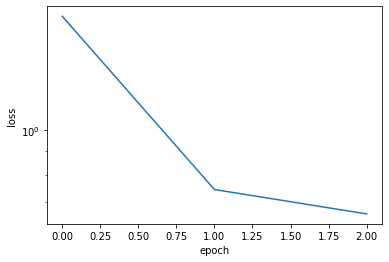

In [24]:
#Now it is time to train the model
opt=tf.keras.optimizers.Adam(learning_rate=.005)#,decay=.97)
huber=tf.keras.losses.Huber(delta=8)
model.compile(loss=huber, optimizer=opt)#metrics=['mean_squared_error','binary_crossentropy'])


sc = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Allow for early stopping so that the model does not overfit the training dataset
es= EarlyStopping(monitor='loss', mode='min',verbose=1,patience=10)

#t0=time.time()
#history= model.fit(inputs,steps_per_epoch=4000,epochs=200,verbose=1, callbacks=[es])
history= model.fit(inputs,epochs=3,batch_size=None)
#t1=time.time()
#print("The total run time to train was %.2f seconds"%(t1-t0))

# plot the loss function
plt.figure()
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')


Using the Model, Predict the DOA's on the Testing Dataset

In [25]:
#use the model to predict on the testing dataset
#for right now test_inputs has only the 40,001 samples
predicted=model.predict(test_inputs, verbose=1)

105691/105691 [==============================] - 154s 1ms/step


In [26]:
print(predicted[10:21])

[[21.22216 ]
 [19.985258]
 [20.551022]
 [21.478878]
 [20.154446]
 [20.400118]
 [20.889366]
 [20.291647]
 [21.087944]
 [20.476809]
 [23.422497]]


In [27]:
print(y_test[10:21])

10     3.408
11    -4.416
12    -8.610
13    -9.828
14     1.494
15     7.938
16     1.500
17     9.294
18     9.642
19    12.750
20    13.080
Name: DOA, dtype: float64


In [ ]:
type(predicted)
predicted.shape

(3410581, 1)

In [28]:
predicted_reshape= predicted.reshape(len(predicted),1)

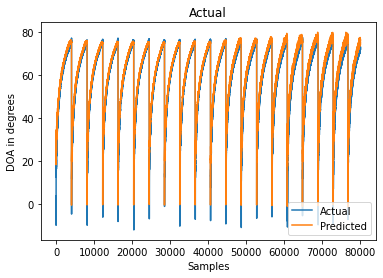

In [29]:
plt.figure(facecolor='white')
plt.plot(y_test[0:80000])
plt.plot(predicted_reshape[0:80000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()



Compare the Actual Testing DOA's to the Predicted DOA's

Put the predicted DOA's back into a csv file format

In [30]:
#Ping |  Num Samp Num | PORT or STBD (0 or 1) |  TWTT |  Predicted DOA   <=======Output columns.
OutputCSVdf=test.iloc[:,[0,1,2,3]]
#OutputCSVdf= pd.DataFrame(test.iloc[:,[0,1,2,3]], columns=['PingNumber','SampNumber','PortStbd', 'SampleTime'])
zerosArray= np.arange(sequence_length)*0
predictedShifted=np.append(zerosArray, predicted)
Predicteddf= pd.DataFrame(predictedShifted,columns=['PredictedDOA'])
OutputCSVdf=OutputCSVdf.join(Predicteddf)

In [31]:
test.iloc[:,[0,1,2,3]]

,PingNum,SampleNum,PortStbd,SampleTimeDelay
0,130701,2078,1,0.031901
1,130701,2080,1,0.031931
2,130701,2081,1,0.031947
3,130701,2082,1,0.031962
4,130701,2083,1,0.031977
...,...,...,...,...
3382107,131577,6473,1,0.099403
3382108,131577,6474,1,0.099419
3382109,131577,6475,1,0.099434
3382110,131577,6476,1,0.099450


In [32]:
zerosArray= np.arange(sequence_length)*0
zerosArray

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [33]:
predictedShifted=np.append(zerosArray, predicted)
predictedShifted

array([ 0.        ,  0.        ,  0.        , ..., 74.49045563,
       74.24172974, 74.23892975])

In [34]:
OutputCSVdf

,PingNum,SampleNum,PortStbd,SampleTimeDelay,PredictedDOA
0,130701,2078,1,0.031901,0.000000
1,130701,2080,1,0.031931,0.000000
2,130701,2081,1,0.031947,0.000000
3,130701,2082,1,0.031962,0.000000
4,130701,2083,1,0.031977,0.000000
...,...,...,...,...,...
3382107,131577,6473,1,0.099403,74.402985
3382108,131577,6474,1,0.099419,74.135681
3382109,131577,6475,1,0.099434,74.490456
3382110,131577,6476,1,0.099450,74.241730


In [35]:
OutputCSVdf.to_csv(path_or_buf="C:\\Users\\rferr\\Desktop\\CSVs\\PredictedOutputTest_NEW_DATA_2.csv")

In [ ]:
tf.keras.models.save_model(model,filepath="C:\\Users\\rferr\\Desktop\\CSVs\\model_Percent.h5")